# Multiple pumps in a circular district heating grid

Based on the simple circular district heating grid.

In [3]:
import pandapipes as pp
import numpy as np

# create empty net
net = pp.create_empty_network(fluid ="water")

In [4]:
# define constants
qext_w = np.array([50000, 20000])
return_temperature_k = np.array([60,55]) + 273.15
supply_temperature_k = 85 + 273.15

pipetype = "110/202 PLUS"
k = 0.1

flow_pressure_pump = 4
lift_pressure_pump = 1.5
mass_pump_mass_flow = 0.5

In [5]:
# Junctions for pump
j1 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 1", geodata=(0, 10))
j2 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 2", geodata=(0, 0))

# Junctions for connection pipes forward line
j3 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 3", geodata=(10, 0))
j4 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 4", geodata=(60, 0))

# Junctions for heat consumers
j5 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 5", geodata=(85, 0))
j6 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 6", geodata=(85, 10))

# Junctions for connection pipes return line
j7 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 7", geodata=(60, 10))
j8 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 8", geodata=(10, 10))

In [6]:
pump1 = pp.create_circ_pump_const_pressure(net, j1, j2, p_flow_bar=flow_pressure_pump,
                                               plift_bar=lift_pressure_pump, t_flow_k=supply_temperature_k,
                                               type="auto", name="pump1")

pipe1 = pp.create_pipe(net, j2, j3, std_type=pipetype, length_km=0.01, k_mm=k, name="pipe1", sections=5, text_k=283)
pipe2 = pp.create_pipe(net, j3, j4, std_type=pipetype, length_km=0.05, k_mm=k, name="pipe2", sections=5, text_k=283)
pipe3 = pp.create_pipe(net, j4, j5, std_type=pipetype, length_km=0.025, k_mm=k, name="pipe3", sections=5, text_k=283)

pp.create_heat_consumer(net, from_junction=j5, to_junction=j6, qext_w=qext_w[0], treturn_k=return_temperature_k[0], name="Consumer A")
pp.create_heat_consumer(net, from_junction=j4, to_junction=j7, qext_w=qext_w[1], treturn_k=return_temperature_k[1], name="Consumer B")

pipe4 = pp.create_pipe(net, j6, j7, std_type=pipetype, length_km=0.25, k_mm=k, name="pipe4", sections=5, text_k=283)
pipe5 = pp.create_pipe(net, j7, j8, std_type=pipetype, length_km=0.05, k_mm=k, name="pipe5", sections=5, text_k=283)
pipe6 = pp.create_pipe(net, j8, j1, std_type=pipetype, length_km=0.01, k_mm=k, name="pipe6", sections=5, text_k=283)

In [7]:
### here comes the part with the additional circ_pump_const_mass_flow ###
# first of, the junctions
j9 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 9", geodata=(100, 0))
j10 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 10", geodata=(100, 10))
j11 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Junction 11", geodata=(100, 5))

pipe7 = pp.create_pipe(net, j5, j9, std_type=pipetype, length_km=0.05, k_mm=k, name="pipe7", sections=5, text_k=283)
pipe8 = pp.create_pipe(net, j10, j6, std_type=pipetype, length_km=0.01, k_mm=k, name="pipe8", sections=5, text_k=283)

pump2 = pp.create_circ_pump_const_mass_flow(net, j10, j11, p_flow_bar=flow_pressure_pump, mdot_flow_kg_per_s=mass_pump_mass_flow, 
                                            t_flow_k=supply_temperature_k, type="auto", name="pump2")

flow_control_pump2 = pp.create_flow_control(net, j11, j9, controlled_mdot_kg_per_s=mass_pump_mass_flow)

The flow control is currently needed for the pressure.


We now run a pipe flow.


In [8]:
pp.pipeflow(net, mode='bidirectional', iter=100)

mode must be bidirectional, iter=100 might be needed

In [9]:
net.res_junction

,p_bar,t_k
0,2.500000,327.891464
1,4.000000,358.150000
2,3.999995,358.078414
3,3.999970,357.609424
4,3.999971,358.049038
5,2.500022,332.661759
6,2.500035,328.149999
7,2.500006,327.934451
8,4.000199,358.150000
9,2.499975,332.648357


Note that a constant heat flow is extracted via the heat exchanger between nodes 1 and 2. Heat
losses due to the ambient temperature level are not taken into account. These are only included in
the pipe components. This also means that - if the extracted heat flow is large enough - the
temperature level behind the heat exchanger might be lower than the ambient temperature level. A
way to avoid this behaviour would be to create a controller which defines a function for the
extracted heat in dependence of the ambient temperature.

In [10]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,t_outlet_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_m3_per_s,reynolds,lambda
0,0.018179,4.000000,3.999995,358.150000,358.078414,358.078414,0.141064,-0.141064,0.000146,5346.846164,0.031545
1,0.018176,3.999995,3.999970,358.078414,357.609424,357.721493,0.141064,-0.141064,0.000146,5333.432050,0.031575
2,-0.002700,3.999970,3.999971,357.609424,358.049038,357.808728,-0.020960,0.020960,-0.000022,788.015150,0.100793
3,-0.002650,2.500022,2.500035,332.661759,328.149999,326.718797,-0.020960,0.020960,-0.000021,496.619942,0.148573
4,0.017863,2.500035,2.500006,328.149999,327.934451,327.934451,0.141064,-0.141064,0.000143,3530.489571,0.037703
5,0.017862,2.500006,2.500000,327.934451,327.891464,327.891464,0.141064,-0.141064,0.000143,3523.145093,0.037741
6,-0.064434,3.999971,4.000199,358.049038,358.150000,358.129797,-0.500000,0.500000,-0.000516,18948.812932,0.022953
7,-0.063463,2.499975,2.500022,332.648357,332.661759,332.659079,-0.500000,0.500000,-0.000508,13423.777747,0.024343


The command above shows the results for the pipe components. The temperatures of the adjacent
junctions are displayed. Due to heat losses, the temperatures at the to-nodes is lower than the
temperatures at the from-nodes. Note also that the junctions are not equal to the internal nodes,
introduced by the pipe sections we defined. To display the temperatures at the internal nodes, we
can retrieve the internal node values with the following commands:

In [11]:
from pandapipes.component_models import Pipe
pipe_results = Pipe.get_internal_results(net, [0])

The parameters of the get_internal_results function correspond to the net and the pipes we want to
evaluate. In this case, only the results of pipe zero are retrieved. The returned value stored in
pipe_results is a dictionary, containing fields for the pressure, the velocity and the temperature.
The dictionary can either be used for own evaluations now or it can be used to plot the results over
the pipe length:


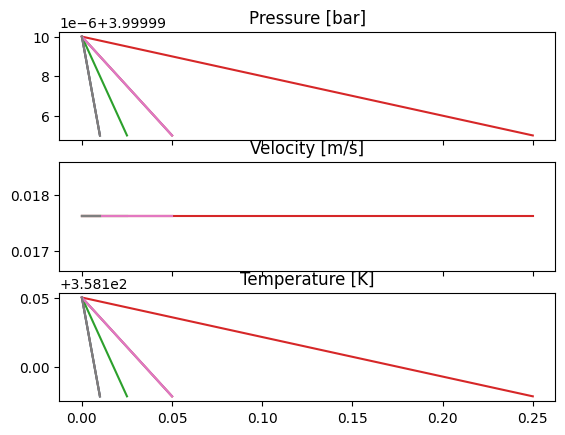

In [12]:
Pipe.plot_pipe(net, 0, pipe_results)

We can see that the pressure level falls due to friction. As the fluid is incompressible, the
velocity remains constant over the pipe length. Because the temperature level at the pipe entry is
higher than the ambient temperature, the temperature level decreases.